In [13]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import os,sys
from sklearn.decomposition import FastICA
from time import time

imdir = 'trap_array_data'
sys.path.append(os.path.join('.',imdir))

In [258]:
def from_csv(fname):
    """convert raveled csv data back into an array of 512 x 512 arrays"""
    with open(fname) as f:
        reader = csv.reader(f, delimiter=',')
        my_data = np.array([row for row in reader])
    data = np.array([np.reshape(x, (512,512)) for x in my_data])
    return data

def from_npy(fname):
    data = np.squeeze(np.load(fname))
    return data

def ica_project(images, components=None, whiten=True):
    """Independent component analysis. returns the data projected on the ICA"""
    X = images.reshape(
        images.shape[0],
        images.shape[1] * images.shape[2]
    ).astype(float)
    
    if components == None:
        components=len(images)
    
    ica = FastICA(n_components=components, max_iter=2000, whiten=whiten)
    ica.fit(X)
    A_ica = ica.components_  # Get estimated mixing matrix
    image_sum = np.sum(np.abs(A_ica),axis=0).reshape(images.shape[1], images.shape[2])
    return image_sum

In [416]:
t0 = time()
bg = from_npy(imdir+'/'+'background_20211210.npy')
time() - t0
print("np.load from npy: ", time()-t0)

np.load from npy:  0.09830307960510254


In [418]:
t0 = time()
img = from_npy(imdir+'/'+'images_20211210.npy')
time() - t0
print("np.load from npy: ", time()-t0)

np.load from npy:  0.13228416442871094


1.6225155649151086 0.8679295449572283


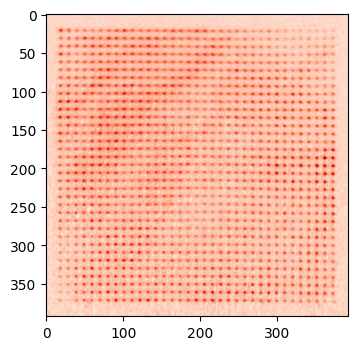

In [524]:
plt.figure(dpi=100)
norm = img[5:].mean(0)/bg[5:].mean(0)
# norm /= np.amax(norm)
print(np.amax(norm),np.amin(norm))
plt.imshow(norm,cmap='Reds',vmin=0.16)#,vmax=0.24)
xmin = 81-8-3 #100
xmax = -55+8-2 #476
ymin = 39-8-2 #40
ymax = 415+8-1 # 350
crop_img = img[4:300,ymin:ymax,xmin:xmax]
crop_bg = bg[4:300,ymin:ymax,xmin:xmax]
plt.imshow(crop_img.mean(0)/crop_bg.mean(0),cmap='Reds')#,vmin=0.2)
plt.show()

In [525]:
crop_img.shape, crop_img.shape[0]/

((296, 393, 393), 74.0)

In [526]:
393/3

131.0

## subarray ICA

### 25 sub arrays

1.6225155649151086 0.8679295449572283
(296, 375, 375)


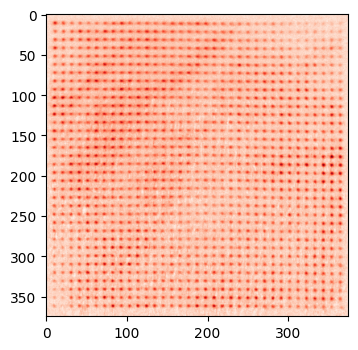

In [583]:
plt.figure(dpi=100)
norm = img[5:].mean(0)/bg[5:].mean(0)
# norm /= np.amax(norm)

print(np.amax(norm),np.amin(norm))
plt.imshow(norm,cmap='Reds',vmin=0.16)#,vmax=0.24)
xmin = 78 #100
xmax = -59 #476
ymin = 39 #40
ymax = -98 # 350
crop_img = img[4:300,ymin:ymax,xmin:xmax]
crop_bg = bg[4:300,ymin:ymax,xmin:xmax]
print(crop_img.shape)
plt.imshow(crop_img.mean(0)/crop_bg.mean(0),cmap='Reds')#,vmin=0.2)
plt.show()

In [632]:
crop_img.shape

(296, 375, 375)

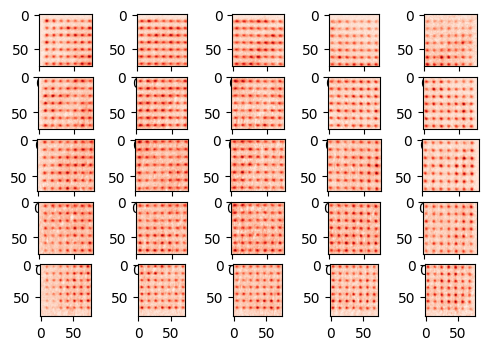

In [636]:
slices = 5
fig,axes = plt.subplots(nrows=slices,ncols=slices,dpi=100)
wdy = int(crop_img.shape[1]/slices)
wdx = int(crop_img.shape[2]/slices)

# offset the sub roi bounds to avoid clipping
dwy = [0,1,0,-4,-5,0] # first digit is unused and should be 0
dwx = [0,2,0,0,-2,0]

for i in range(slices):
    for j in range(slices):
        idx_x1 = j*wdx+dwx[j]
        idx_x2 = (j+1)*wdx+dwx[j+1]
        idx_y1 = i*wdy+dwy[i]
        idx_y2 = (i+1)*wdy+dwy[i+1]
        axes[i,j].imshow((crop_img.mean(0)/crop_bg.mean(0))[idx_y1:idx_y2,
                                                            idx_x1:idx_x2],
                                                            cmap='Reds')#,vmin=0.1

In [637]:
sites_arr = np.array([[7*7,7*7,7*7,7*7,7*7],
                      [7*7,7*7,7*7,7*7,7*7],
                      [7*7,7*7,7*7,7*7,7*7],
                      [7*7,7*7,7*7,7*7,7*7],
                      [7*7,7*7,7*7,7*7,7*7],
                     ])
assert np.sum(sites_arr) == 1225

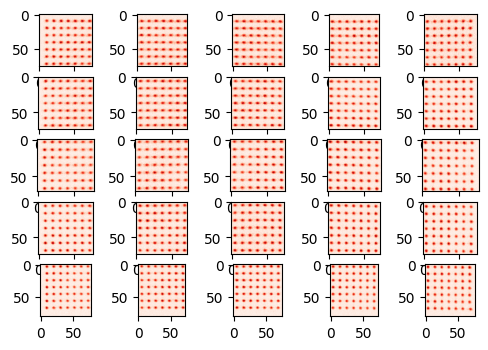

In [639]:
fig,axes = plt.subplots(nrows=slices,ncols=slices,dpi=100)

ica_img = np.empty(crop_img[0].shape,float)

frames = 300

for i in range(slices):
    for j in range(slices):
        
        idx_x1 = j*wdx+dwx[j]
        idx_x2 = (j+1)*wdx+dwx[j+1]
        idx_y1 = i*wdy+dwy[i]
        idx_y2 = (i+1)*wdy+dwy[i+1]
        
        sub_img = crop_img[:frames, idx_y1:idx_y2, idx_x1:idx_x2]/crop_bg[:frames, idx_y1:idx_y2, idx_x1:idx_x2].mean(0)
        ica_sub = ica_project(sub_img,whiten=True, components=sites_arr[i,j])
        ica_img[idx_y1:idx_y2, idx_x1:idx_x2] = ica_sub
        
        axes[i,j].imshow(ica_sub,cmap='Reds')

wrote file to ./trap_array_data/ica_img_20211210_full_array_reds_no_frame.png


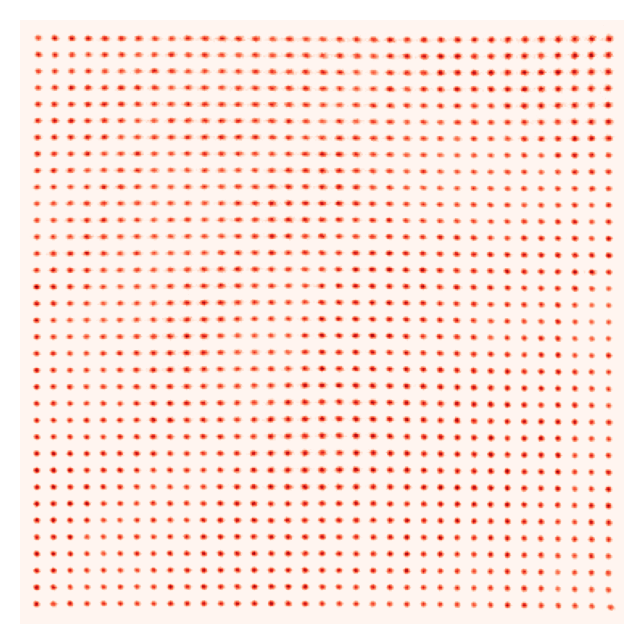

In [645]:
plt.figure(dpi=200)
plt.imshow(ica_img,cmap='Reds',vmin=0.02)#,vmin=0.0375)#,vmax=0.11)
# plt.xlim((0,365))
# plt.ylim((0,365))

plt.xticks([])
plt.yticks([])
plt.box(on=None)
# fname = './'+imdir+'/ica_img_20211210_full_array_reds_no_frame.png'
# plt.savefig(fname,bbox_inches='tight')
# print(f"wrote file to {fname}")

In [642]:
np.amin(ica_img), np.amax(ica_img)

(0.005366842340577125, 0.08039928987130439)

### 9 sub arrays

1.6225155649151086 0.8679295449572283


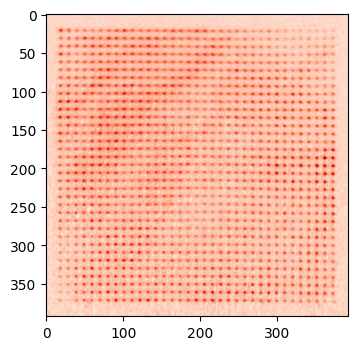

In [524]:
plt.figure(dpi=100)
norm = img[5:].mean(0)/bg[5:].mean(0)
# norm /= np.amax(norm)
print(np.amax(norm),np.amin(norm))
plt.imshow(norm,cmap='Reds',vmin=0.16)#,vmax=0.24)
xmin = 81-8-3 #100
xmax = -55+8-2 #476
ymin = 39-8-2 #40
ymax = 415+8-1 # 350
crop_img = img[4:300,ymin:ymax,xmin:xmax]
crop_bg = bg[4:300,ymin:ymax,xmin:xmax]
plt.imshow(crop_img.mean(0)/crop_bg.mean(0),cmap='Reds')#,vmin=0.2)
plt.show()

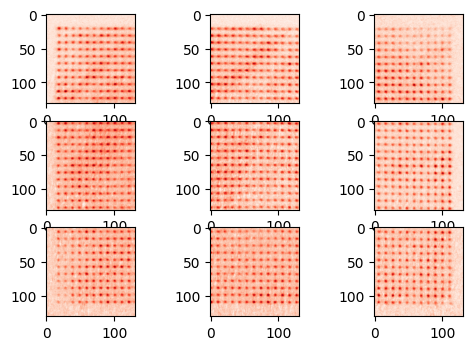

In [528]:
slices = 3
fig,axes = plt.subplots(nrows=slices,ncols=slices,dpi=100)
wd = int(crop_img.shape[1]/slices)
# xoffset = 
for i in range(slices):
    for j in range(slices):
        axes[i,j].imshow((crop_img.mean(0)/crop_bg.mean(0))[i*wd:(i+1)*wd,j*wd:(j+1)*wd],cmap='Reds')#,vmin=0.1

In [530]:
sites_arr = np.array([[11*11,11*13,11*11],
                      [13*11,13*13,13*11],
                      [11*11,11*13,11*11]])
assert np.sum(sites_arr) == 1225

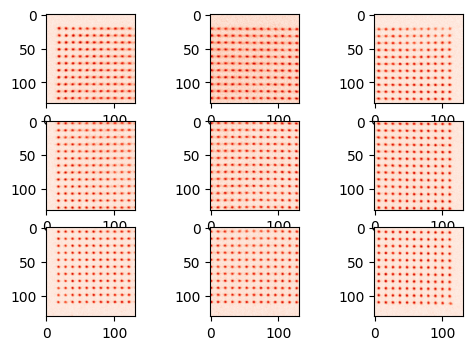

In [533]:
fig,axes = plt.subplots(nrows=slices,ncols=slices,dpi=100)

ica_img = np.empty(crop_img[0].shape,float)

dx = dy = int(crop_img[1].shape[1]/slices)
frames = 300
sites_arr = np.array([[11*11,11*13,11*11],
                      [13*11,13*13,13*11],
                      [11*11,11*13,11*11]])

for i in range(slices):
    for j in range(slices):
        
        sub_img = crop_img[:frames, i*dx:(i+1)*dx, j*dy:(j+1)*dy]/crop_bg[:frames, i*dx:(i+1)*dx, j*dy:(j+1)*dy].mean(0)
        ica_sub = ica_project(sub_img,whiten=True, components=sites_arr[i,j])
        ica_img[i*dx:(i+1)*dx, j*dy:(j+1)*dy] = ica_sub
        
        axes[i,j].imshow(ica_sub,cmap='Reds')

wrote file to ./trap_array_data/ica_img_20211210_reds_no_frame.png


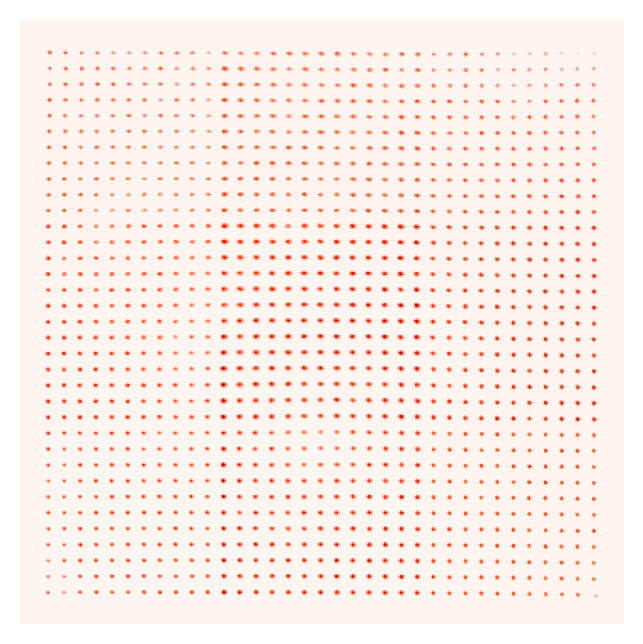

In [545]:
plt.figure(dpi=200)
plt.imshow(ica_img,cmap='Reds',vmin=0.0375)#,vmax=0.11)
# plt.xlim((0,365))
# plt.ylim((0,365))

plt.xticks([])
plt.yticks([])
plt.box(on=None)
fname = './'+imdir+'/ica_img_20211210_reds_no_frame.png'
plt.savefig(fname,bbox_inches='tight')
print(f"wrote file to {fname}")

In [537]:
np.amax(ica_img)

0.09154417326850307

## histogram
run cells above to load images and slice into subregions

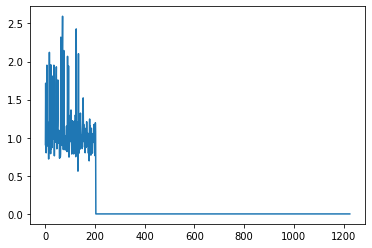

In [398]:
i = j = 1
subimg = (crop_img/crop_bg.mean(0))[:,i*93:(i+1)*93,j*93:(j+1)*93]
plt.plot(range(len(subimg)),subimg[:,7,4])
# plt.imshow(subimg.mean(0))

In [395]:
subimg[:100,7,4]

array([0.9095912 , 1.71528245, 1.04198587, 0.80195831, 1.13667792,
       1.17388281, 1.95207479, 0.89067767, 1.21258088, 1.19180089,
       0.97143345, 1.08180381, 0.85011314, 0.72058039, 0.93858364,
       1.01498432, 2.12055448, 1.07981292, 1.09038956, 0.98337883,
       0.92775814, 0.79063509, 1.95605659, 0.85023757, 1.01573091,
       0.9260161 , 0.8687778 , 0.90013444, 1.0809328 , 1.0088872 ,
       1.19814687, 1.81134324, 1.05778862, 0.9868629 , 1.95157707,
       1.89832057, 0.76238923, 1.31225018, 1.00453211, 0.99283559,
       0.93995238, 1.21046555, 0.9904714 , 1.71602903, 1.92992606,
       1.16007096, 0.85409494, 1.09810429, 1.15335169, 1.33526993,
       1.75771344, 1.11925757, 0.92838029, 1.07371579, 1.06562777,
       1.09598896, 1.04596766, 0.73065931, 1.07657771, 0.88408283,
       0.74795523, 0.7918794 , 2.31951977, 1.04447449, 0.96944255,
       0.97516638, 2.29538014, 0.89864126, 2.15937697, 2.59413917,
       1.14762786, 0.96110567, 0.84488704, 0.95438639, 2.14419

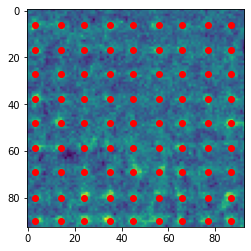

In [355]:
# fig,ax = plt.subplots()
plt.imshow(subimg.mean(0))
dx = 3
dy = 6
# for i in range(9):
#     plt.axvline(dx+i*10.5, linewidth=1, color='r')
# for j in range(9):
#     plt.axhline(dy+j*10.5, linewidth=1, color='r')

for i in range(9):
    for j in range(9):
        plt.scatter(int(dx+i*10.5+0.5), int(dy+j*10.5+0.5), marker='o',color='r')

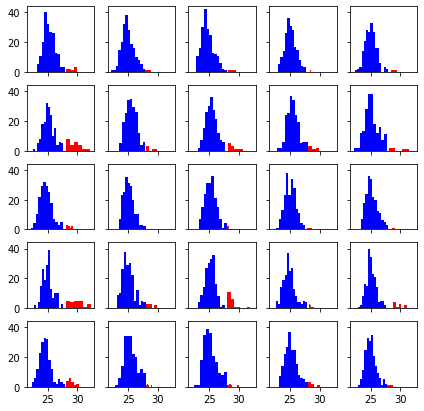

In [415]:
nx = ny = 2
nrows = ncols = 5
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7,7),sharex=True,sharey=True)
# fig.tight_layout()

for i in range(nrows):
    for j in range(ncols):
        roi_stack = subimg[:200,int(dx+i*10.5+0.5)-nx:int(dx+i*10.5+0.5)+nx+1, int(dy+j*10.5+0.5)-ny:int(dy+j*10.5+0.5)+ny+1]
        counts = np.array([np.sum(frame) for frame in roi_stack])
    
        cutoff = 28
        no_atom = [x for x in counts if x < cutoff]
        atom = [x for x in counts if x >= cutoff]
        
        axes[i,j].hist(no_atom, bins='auto',color='blue')
        axes[i,j].hist(atom, bins='auto',color='red')
#         axes[i,j].hist(counts,bins='auto',color='green')
#         axes[i,j].set_xlim((2,35))

(array([1.023e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        3.000e+00, 1.400e+01, 1.300e+0

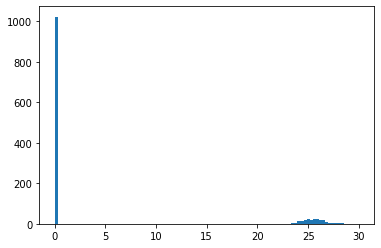

In [389]:
plt.hist(counts,bins=np.linspace(0,30,100))

In [387]:
no_atom

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

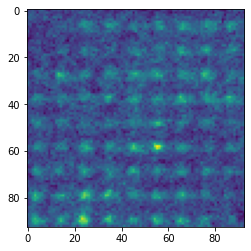

In [253]:
# fast ica on just one sub-image
i=j=0
plt.imshow((crop_img.mean(0)/crop_bg.mean(0))[i*93:(i+1)*93,j*93:(j+1)*93])#,cmap='Reds',vmin=0.16)

In [227]:
np.amax(crop_img[:78]),np.amin(crop_img[:78]),

(26412, 3477)

In [237]:
(crop_img[:sites]/np.amax(crop_img[:sites])).shape

(78, 372, 372)

In [267]:
81*16

1296

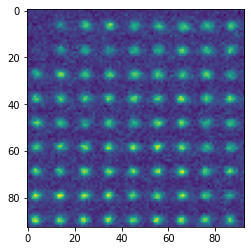

In [264]:
dx = dy = 93
frames = 200
sites = 81
sub_img = crop_img[:frames, :dx, :dy]/crop_bg[:frames, :dx, :dy].mean(0)
sub_bg = crop_bg[:sites, :dx, :dy]
# plt.imshow(subarr)
ica_img = ica_project(sub_img,whiten=True, components=sites)
ica_bg = ica_project(sub_bg)

plt.imshow(ica_img)

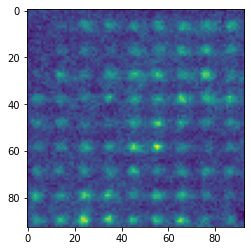

In [256]:
plt.imshow(sub_img.mean(0))

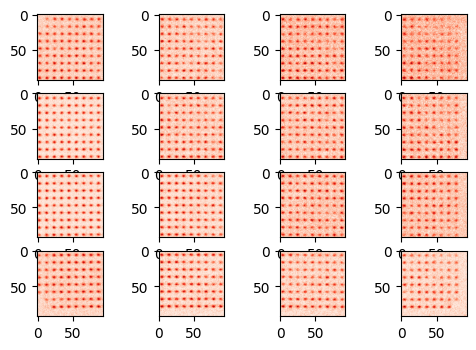

In [271]:
fig,axes = plt.subplots(nrows=4,ncols=4,dpi=100)

ica_img = np.empty(crop_img[0].shape,float)

dx = dy = 93
frames = 200
sites_arr = np.array([[81,81,81,72],
                      [81,81,81,72],
                      [81,81,81,72],
                      [72,72,72,64]])

for i in range(4):
    for j in range(4):
        
        sub_img = crop_img[:frames, i*dx:(i+1)*dx, j*dy:(j+1)*dy]/crop_bg[:frames, i*dx:(i+1)*dx, j*dy:(j+1)*dy].mean(0)
        ica_sub = ica_project(sub_img,whiten=True, components=sites_arr[i,j])
        ica_img[i*dx:(i+1)*dx, j*dy:(j+1)*dy] = ica_sub
        
        axes[i,j].imshow(ica_sub,cmap='Reds')

wrote file to ./trap_array_data/ica_img_20211209_reds_no_frame.png


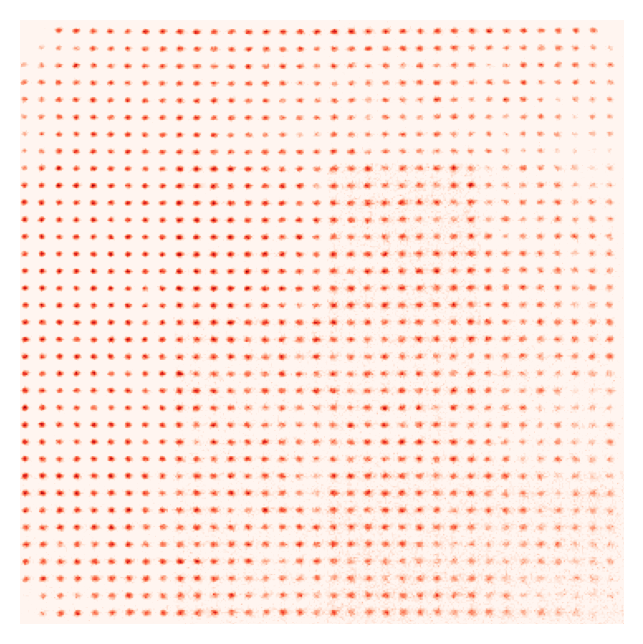

In [314]:
plt.figure(dpi=200)
plt.imshow(ica_img,cmap='Reds',vmin=0.0375)
plt.xlim((0,365))
plt.ylim((0,365))

plt.xticks([])
plt.yticks([])
plt.box(on=None)
# fname = './'+imdir+'/ica_img_20211209_reds_no_frame.png'
# plt.savefig(fname,bbox_inches='tight')
# print(f"wrote file to {fname}")

In [278]:
np.amax(ica_img)

0.0960632574525508